In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import math
import torch.nn.functional as F
from torch.utils.data import TensorDataset, random_split, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch.nn.utils.rnn as rnn_utils

#Problem 1:

In [ ]:
# Setting device for GPU acceleration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Loading MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(testset, batch_size=64, shuffle=False)

Using device: cpu


100%|██████████| 9912422/9912422 [00:00<00:00, 100085727.39it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 25236602.88it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27918742.90it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11414337.19it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# NN class definition
class DynamicMNISTModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation_flag=0):
        super(DynamicMNISTModel, self).__init__()
        self.flatten = nn.Flatten()
        layers = []

        # Choosing the activation function based on activation_flag
        if activation_flag == 1:
            activation = nn.Sigmoid()
        elif activation_flag == 2:
            activation = nn.Tanh()
        elif activation_flag == 3:
            activation = nn.ELU()
        else:
            # Default is ReLU
            activation = nn.ReLU()

        if len(hidden_sizes) == 0:
            # No hidden layers, only input and output layers
            layers.append(nn.Linear(input_size, output_size))
        else:
            # First layer
            layers.append(nn.Linear(input_size, hidden_sizes[0]))
            layers.append(nn.LayerNorm(hidden_sizes[0]))
            layers.append(activation)
            # Hidden layers
            for i in range(1, len(hidden_sizes)):
                layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
                layers.append(nn.LayerNorm(hidden_sizes[i]))
                layers.append(activation)
            # Output layer
            layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = self.flatten(x)
        return self.network(x)

In [ ]:
# SGD Optimizer
def SGD_optim(model):
    return optim.SGD(model.parameters(), lr=0.0015, momentum=0.9)

In [ ]:
# Adam Optimizer
def Adam_optim(model):
    return optim.Adam(model.parameters(), lr=0.0015)

In [ ]:
# Training & Testing Model
def train_and_test_model(model, train_loader, test_loader, epochs=10, flag=1):
    optimizer = SGD_optim(model) if flag == 1 else Adam_optim(model)
    loss_function = nn.CrossEntropyLoss()
    model.to(device)

    total_training_time = 0

    for epoch in range(epochs):
        total_train_loss, total_train_samples = 0, 0
        total_test_loss, total_test_samples = 0, 0

        start_time = time.time()

        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            train_loss = loss_function(outputs, labels)
            train_loss.backward()
            optimizer.step()

            total_train_loss += train_loss.item() * labels.size(0)
            total_train_samples += labels.size(0)

        total_training_time += time.time() - start_time

        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                test_loss = loss_function(outputs, labels)

                total_test_loss += test_loss.item() * labels.size(0)
                total_test_samples += labels.size(0)

    average_train_loss_last_epoch = total_train_loss / total_train_samples
    average_test_loss_last_epoch = total_test_loss / total_test_samples
    print(f"train loss={average_train_loss_last_epoch}, test loss={average_test_loss_last_epoch}")

    return average_train_loss_last_epoch, average_test_loss_last_epoch, total_training_time

In [ ]:
def Problem4(hidden_sizes):
    model = DynamicMNISTModel(28*28, hidden_sizes, 10).to(device)
    avg_train_loss1, avg_test_loss1, train_time1 = train_and_test_model(model, train_loader, test_loader)
    return model

In [ ]:
# Train & Test for Decreasing size - best model from P4
hidden_sizes = [575, 475, 375, 250]
modelP4 = Problem4(hidden_sizes)

train loss=0.016592147344350813, test loss=0.06437768416907638


In [ ]:
# Train & Test for base softmax model
hidden_sizes = []
modelbase = Problem4(hidden_sizes)

train loss=0.2889441215912501, test loss=0.28367612758874894


In [ ]:
modelP4.eval()
modelbase.eval()

DynamicMNISTModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (network): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
  )
)

In [ ]:
# Generating initial random images for optimization.
initial_images = torch.rand(10, 1, 28, 28, requires_grad=True)

# Regularization strength parameter to control the L2 regularization term.
lambda_reg = 0.1

# Function to optimize an image to maximize the probability of a target digit classification.
def optimize_image(model, target_digit, initial_image, iterations=1000, learning_rate=0.01):
    image = initial_image.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([image], lr=learning_rate)

    for i in range(iterations):
        optimizer.zero_grad()
        output = model(image)
        # Computing the log probabilities using a softmax function.
        log_probs = F.log_softmax(output, dim=1)
        # Calculate the loss as the negative log probability of the target digit.
        loss = -log_probs[0, target_digit]

        # Add the L2 regularization term to the loss.
        l2_reg = lambda_reg * torch.sum(image ** 2)
        total_loss = loss + l2_reg

        total_loss.backward()
        optimizer.step()

        # Clamp the image data to be within the valid range of [0, 1] after each update.
        image.data = image.data.clamp_(0, 1)
    return image.detach()

In [ ]:
# Generate optimized images for each digit using the base model.
optimized_images_simple = [optimize_image(modelbase, digit, initial_images[digit].unsqueeze(0)) for digit in range(10)]

# Generate optimized images for each digit using the more complex model from P4.
optimized_images_complex = [optimize_image(modelP4, digit, initial_images[digit].unsqueeze(0)) for digit in range(10)]

Base Model: 0 to 9 images


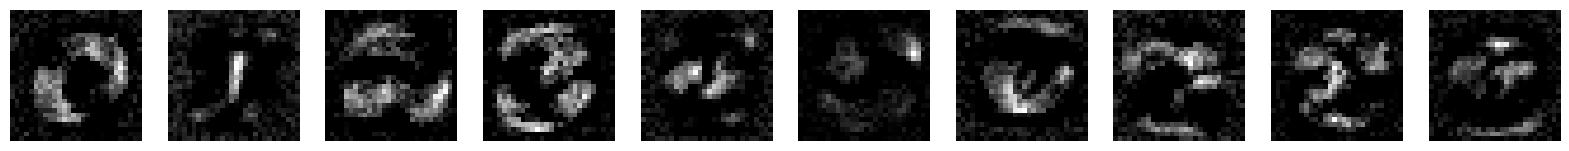

P4 Model: 0 to 9 images


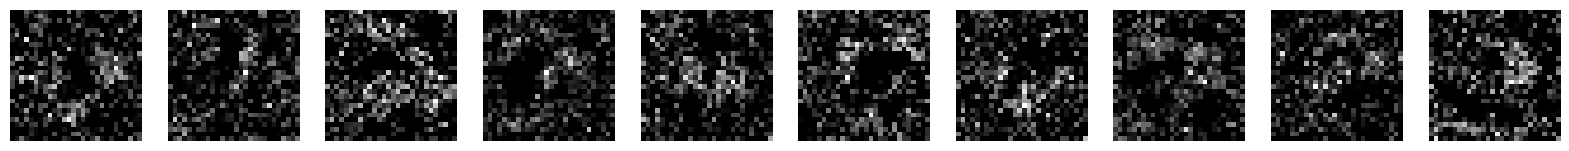

In [ ]:
def show_images(images):
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    for i, ax in enumerate(axes):
        ax.imshow(images[i].squeeze().cpu().numpy(), cmap='gray')
        ax.axis('off')
    plt.show()

# Converting the list of tensors to a tensor for easy manipulation
optimized_images_simple_tensor = torch.cat([img for img in optimized_images_simple], dim=0)
optimized_images_complex_tensor = torch.cat([img for img in optimized_images_complex], dim=0)

print("Base Model: 0 to 9 images")
show_images(optimized_images_simple_tensor)
print("P4 Model: 0 to 9 images")
show_images(optimized_images_complex_tensor)

Base Model: 0 to 9 images


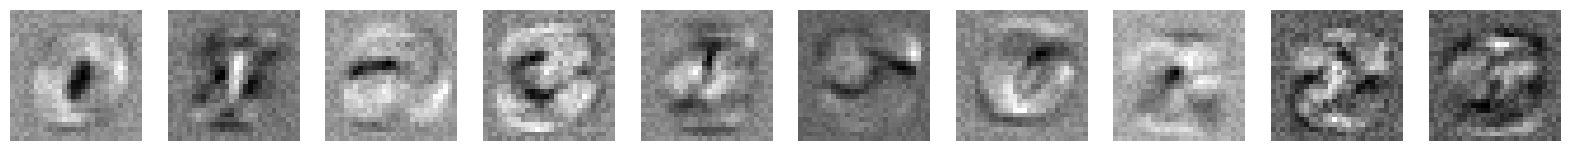

P4 Model: 0 to 9 images


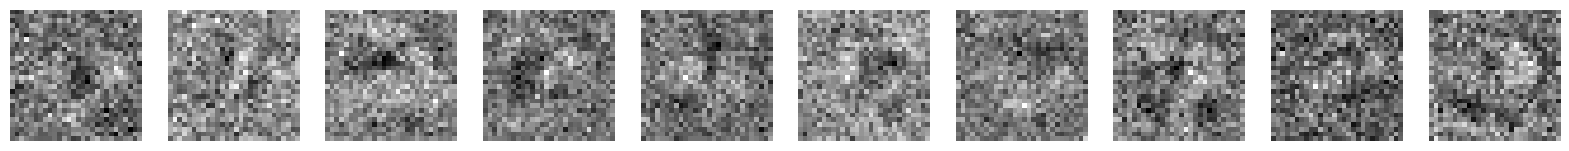

In [ ]:
# clamped -0.5 to 0.5 (not required - but just attached for additional observation)
# re-ran the above code with one modification - in the optimize_image function change "image.data = image.data.clamp_(0, 1) to the following:
# image.data = image.data.clamp_(-0.5, 0.5)

**Notes on Problem 1:**
- The images were optimized using Adam optimizer with a learning rate of 0.01

**Q. How can you formulate this as a minimization problem? What would the variables be, and what would the loss function be? Note: Regularization may be useful here.**

Ans:
- **Minimization:** By minimizing the loss function we calculate how unlikely it is for a modified input image to be classified as the target digit by the NN model. This is achieved by optimizing the pixel values of an initial image so that the model's predicted probability for the target digit is maximized, which is equivalent to minimizing the negative log probability for that digit.
- **Variables:** The variables in this optimization problem are the pixel values of the image being optimized. These pixels are represented as tensor and are initialized at random.
- **Loss Function:** The primary component is the negative log probability of the traget digit's class in the model's output distribution. This can be achieved by applying the softmax function to the logits output by the model and then taking the logarithm. The second component is the **L2 regularization** term, which penalizes large pixel values to avoid overfitting to the model's predictions and to keep the optimized image within a realistic range.
- Additionally, the vector image was **clamped** to constrian the values within a valid range. The output above is for two different ranges: (0, 1) and (-0.5, 0.5).

**Q. Formulate how to solve the problem for the optimal digit images**

Ans: To solve for the optimal digit images, we formula as a optimization problem where the goal is to modify pixels of an initially randomly generated image such that a trained NN model assigns the highest possible probability to the corresponding target digit class. The detailed formualtion is described in the steps above (Minimization, Variables, Loss Function, Clamping).
Additional details: We will run the optimization loop for some fixed iterations. We will use Adam optimizer to optimize the images. We will use back propogation to compute gradients of the loss function with respect to the image pixels.

**Q. Find and display the ten optimal images for the no hidden layer network.**

Ans: Displayed above (This is labeled as "Base Model: 0 to 9 images" in the output. The images are displayed horizontally in the order 0 to 9)

**Q. Find and display the ten optimal images for the optimal network**

Ans: Displayed above (This is labeled as "P4 Model: 0 to 9 images" in the output. The images are displayed horizontally in the order 0 to 9)
The optimal network here is the best network that was observed from HW 2 Problem 4.

**Q. What do the images suggest about what the two networks are looking for, in terms of features? Any similarities or differences?**

Ans:

Base Model: The base model has no hidden layers and so it can't learn any complex features or patterns. It can only learn the most simplest form of the images. The most simplest feature or form of the image is the correct image itself. It learns to recognize digits by identifying and using simple patterns that correspond to the actual data. So, when optimizing using base model, we see the images generated correspond to the actual digits.

P4 Model: In contrast, the images optimized for the P4 model, which is a more complex model with multiple hidden layers can learn more complex features and patterns. So, the generated images doesn't necessarily have to correspond to the actual clear digits. From the generated images we can conclude that they learn features such as edges, corners, or complex pattern of actual digit images. This are not visible clearly as digits to human eye (From the output we can confirm that they somewhat correspond to actual digit images but it's hard to trace and identify). The P4 model is better than Base model because of these complex features that the P4 model has learned. As a result, P4 model can predict better in case the images are presented in various forms.

Similarity: In essence, both models are looking for patterns/features that increase the probability of the desired classification.

Difference: The key difference is the level of complexity of the features each model is focusing on.

In summary, the base model relies on simpler, more obvious features that closely resemble the digits, while the P4 model relies on complex patterns that may capture more abstract representations of the digits.

**Bonus:**

**How should you decide when to stop training? What does overfitting/over training mean here?**

Ans: Early Stopping can be used to prevent overfitting. We can monitor loss on the testing data or validation data and if the model's performance starts to worsen, we stop the the training process at this point.

We can use the "best_loss" parameter which keeps track of the lowest loss so far. We can have a "patience" parameter that keeps track of the count/resistance/patience for which we want to allow the model to run. For example, is patience is set to 3. We will wait for 3 consecutive runs. If all 3 runs had loss increasing compared to best_loss observed we terminate the training loop.

Overfitting/Overtraining here would occur as a result of access optimization or training. As a result, the optimized images become over specialized to the model used for optimization. They start to learn the features of the digit so well that they loose their complexity and loose ability to generalize well on the unseen data.

#Problem 2:

In [2]:
def generate_data(num_sequences=25000, max_sequence_length=100, min_sequence_length=1, change_point_limit=100):
    sequences = []
    labels = []

    for _ in range(num_sequences):
        sequence_length = np.random.randint(min_sequence_length, max_sequence_length + 1)
        change_point = np.random.randint(0, change_point_limit)

        sequence = np.random.normal(0, 1, (sequence_length, 10))

        label = np.zeros(sequence_length)

        if change_point < sequence_length:
            change_indices = np.random.choice(10, 5, replace=False)
            change_values = np.random.uniform(-1, 1, size=5)

            for t in range(change_point, sequence_length):
                sequence[t, change_indices] += change_values
                label[t] = 1

        sequences.append(sequence)
        labels.append(label)

    return sequences, labels

sequences, labels = generate_data()

**Part 1: Change Point Detection using RNN's**

In [ ]:
class VariableLengthSequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = [torch.tensor(sequence, dtype=torch.float32) for sequence in sequences]
        self.labels = [torch.tensor(label, dtype=torch.float32) for label in labels]

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

def collate_fn(batch):
    sequences, labels = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True)
    labels_padded = pad_sequence(labels, batch_first=True)
    return sequences_padded, labels_padded

In [ ]:
full_dataset = VariableLengthSequenceDataset(sequences, labels)

num_train = int(0.8 * len(full_dataset))
num_test = len(full_dataset) - num_train
train_dataset, test_dataset = random_split(full_dataset, [num_train, num_test])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=10, hidden_size=20, num_layers=2, batch_first=True)
        self.layer_norm = nn.LayerNorm(20)
        self.fc = nn.Linear(20, 1)

    def forward(self, x, lengths):
        packed_x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_x)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        output = self.layer_norm(output)
        output = self.fc(output)
        return torch.sigmoid(output)

lstmModel = LSTMModel()

In [ ]:
# training and testing lstmModel
criterion = nn.BCELoss()
optimizer = optim.Adam(lstmModel.parameters(), lr = 0.001)

for epoch in range(15):
    # Training phase
    lstmModel.train()
    total_loss = 0
    for seqs, lbls in train_dataloader:
        lengths = [len(seq) for seq in seqs]

        optimizer.zero_grad()
        outputs = lstmModel(seqs, lengths)
        loss = criterion(outputs.squeeze(), lbls)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_dataloader)

    # Evaluation phase
    lstmModel.eval()
    total_loss = 0
    with torch.no_grad():
        for seqs, lbls in test_dataloader:
            lengths = [len(seq) for seq in seqs]

            outputs = lstmModel(seqs, lengths)
            loss = criterion(outputs.squeeze(), lbls)
            total_loss += loss.item()
    avg_test_loss = total_loss / len(test_dataloader)

    print(f'Epoch {epoch+1}, Train loss = {avg_train_loss:.4f}, Test loss = {avg_test_loss:.4f}')

Epoch 1, Train loss = 0.5699, Test loss = 0.4516
Epoch 2, Train loss = 0.4600, Test loss = 0.4329
Epoch 3, Train loss = 0.4280, Test loss = 0.4007
Epoch 4, Train loss = 0.3783, Test loss = 0.3484
Epoch 5, Train loss = 0.3300, Test loss = 0.3019
Epoch 6, Train loss = 0.2922, Test loss = 0.2695
Epoch 7, Train loss = 0.2665, Test loss = 0.2483
Epoch 8, Train loss = 0.2459, Test loss = 0.2319
Epoch 9, Train loss = 0.2301, Test loss = 0.2207
Epoch 10, Train loss = 0.2214, Test loss = 0.2141
Epoch 11, Train loss = 0.2180, Test loss = 0.2131
Epoch 12, Train loss = 0.2132, Test loss = 0.2070
Epoch 13, Train loss = 0.2047, Test loss = 0.2001
Epoch 14, Train loss = 0.2007, Test loss = 0.1958
Epoch 15, Train loss = 0.1963, Test loss = 0.2011


In [ ]:
def evaluate_and_plot(model, test_dataloader):
    distances = list(range(-10, 11))
    detection_probabilities = {distance: [] for distance in distances}

    model.eval()
    with torch.no_grad():
        for sequences, labels in test_dataloader:
            lengths = [len(seq) for seq in sequences]

            sequences_tensor = torch.stack(sequences) if not isinstance(sequences[0], torch.Tensor) else sequences
            labels_tensor = torch.stack(labels) if not isinstance(labels[0], torch.Tensor) else labels

            outputs = model(sequences_tensor, lengths).squeeze()

            for i, length in enumerate(lengths):
                label = labels_tensor[i][:length]
                nonzero_elements = label.nonzero(as_tuple=False).squeeze()
                if nonzero_elements.numel() > 0:
                    change_point = nonzero_elements.min().item()

                    for distance in distances:
                        timestep = change_point + distance
                        if 0 <= timestep < length:
                            detection_probabilities[distance].append(outputs[i, timestep].item())

    avg_detection_probabilities = {distance: np.mean(probabilities) if probabilities else 0
                                   for distance, probabilities in detection_probabilities.items()}

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(distances, list(avg_detection_probabilities.values()), marker='.', linestyle='-')
    plt.xlabel("Distance from Change Point")
    plt.ylabel("Detection Probability")
    plt.title("Detection Probability vs. Distance from Change Point")
    plt.grid(True)
    plt.show()

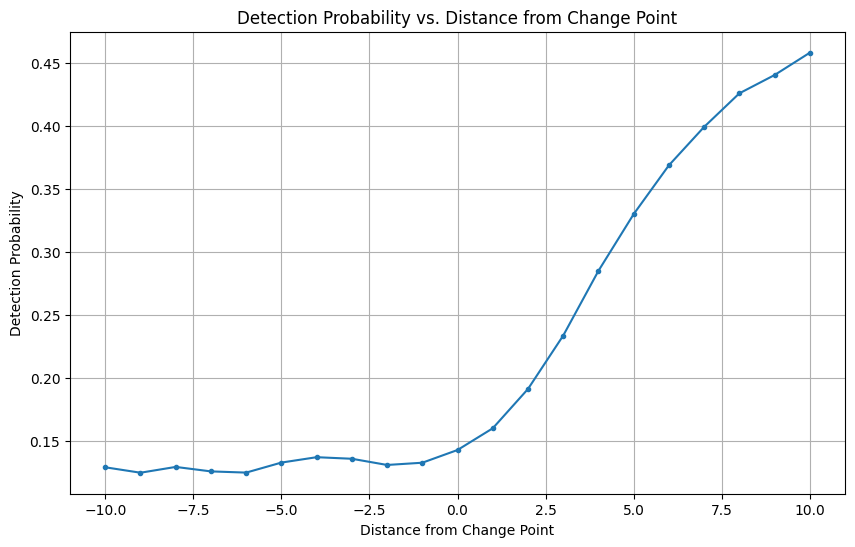

In [ ]:
evaluate_and_plot(lstmModel, test_dataloader)

**Part 2: Change Point Detection using CNN's**

In [10]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(10, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.conv4 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm1d(256)
        self.conv5 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.dropout(x)
        x = x.permute(0, 2, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x.squeeze(-1)

In [13]:
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for sequences, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)

        # Testing loop
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for sequences, labels in test_loader:
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                total_test_loss += loss.item()
        avg_test_loss = total_test_loss / len(test_loader)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

cnnModel = CNNModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(cnnModel.parameters(), lr=0.001)

train_and_evaluate(cnnModel, train_dataloader, test_dataloader, criterion, optimizer, epochs=15)

Epoch 1/15, Train Loss: 0.3430, Test Loss: 0.3132
Epoch 2/15, Train Loss: 0.2679, Test Loss: 0.2720
Epoch 3/15, Train Loss: 0.2440, Test Loss: 0.3054
Epoch 4/15, Train Loss: 0.2296, Test Loss: 0.2536
Epoch 5/15, Train Loss: 0.2137, Test Loss: 0.2473
Epoch 6/15, Train Loss: 0.2015, Test Loss: 0.2205
Epoch 7/15, Train Loss: 0.1942, Test Loss: 0.2871
Epoch 8/15, Train Loss: 0.1850, Test Loss: 0.2303
Epoch 9/15, Train Loss: 0.1778, Test Loss: 0.2154
Epoch 10/15, Train Loss: 0.1701, Test Loss: 0.2312
Epoch 11/15, Train Loss: 0.1613, Test Loss: 0.2228
Epoch 12/15, Train Loss: 0.1557, Test Loss: 0.2630
Epoch 13/15, Train Loss: 0.1447, Test Loss: 0.3249
Epoch 14/15, Train Loss: 0.1384, Test Loss: 0.2429
Epoch 15/15, Train Loss: 0.1318, Test Loss: 0.2578


In [ ]:
def evaluate_and_plot(model, test_loader):
    model.eval()
    distances = list(range(-10, 11))
    detection_probabilities = {distance: [] for distance in distances}

    with torch.no_grad():
        for sequences, labels in test_loader:
            outputs = model(sequences)

            for batch_index in range(len(labels)):
                change_points = (labels[batch_index] == 1).nonzero(as_tuple=False)

                if change_points.nelement() == 0:
                    continue

                change_point = change_points[0, 0].item()

                for distance in distances:
                    timestep = change_point + distance
                    if 0 <= timestep < labels.size(1):
                        detection_probability = outputs[batch_index, timestep].item()
                        detection_probabilities[distance].append(detection_probability)

    avg_detection_probs = [np.mean(detection_probabilities[dist]) if detection_probabilities[dist] else 0 for dist in distances]

    plt.figure(figsize=(10, 6))
    plt.plot(distances, avg_detection_probs, marker='o', linestyle='-', color='blue')
    plt.xlabel('Distance from Change Point')
    plt.ylabel('Average Detection Probability')
    plt.title('Detection Probability vs. Distance from Change Point')
    plt.grid(True)
    plt.show()

evaluate_and_plot(cnnModel, test_dataloader)

#Problem 3: